<a href="https://colab.research.google.com/github/vishal0143/ML-Algorithms/blob/main/Transfer_Learning_Types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from subprocess import call
import os
from urllib.request import urlretrieve
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

dataset_url = "http://aisdatasets.informatik.uni-freiburg.de/" \
              "freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz"

def download():
    print("Downloading dataset.")
    urlretrieve(dataset_url, "freiburg_groceries_dataset.tar.gz")
    print("Extracting dataset.")
    call(["tar", "-xf", "freiburg_groceries_dataset.tar.gz", "-C", "."])
    os.remove("freiburg_groceries_dataset.tar.gz")
    print("Done.")

    
def load_data():
    if (not os.path.exists("images")):
        download()
        
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    class_names = []
    category_num = 0
    
    for category in sorted(os.listdir("images")):
        class_names.append(category)
        count = 0
        for img in sorted(os.listdir(os.path.join("images", category))):
            if (not img.endswith(".png")):
                continue
                
            x = load_img(os.path.join("images", category, img),target_size=(224, 224))
            if count < 10:
                x_test.append(img_to_array(x))
                y_test.append(category_num)
            else:
                x_train.append(img_to_array(x))
                y_train.append(category_num)
            count += 1
        category_num += 1
    return (np.array(x_train), np.array(y_train)), (np.array(x_test), np.array(y_test)), class_names


In [2]:
import os
#os.environ["WANDB_ENTITY"] = "mlclass"
import keras
#import wandb
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.applications.resnet50 import ResNet50, decode_predictions, preprocess_input
import matplotlib.pyplot as plt
#from wandb.keras import WandbCallback

In [3]:
(x_train,y_train_raw),(x_test,y_test_raw), class_names = load_data()

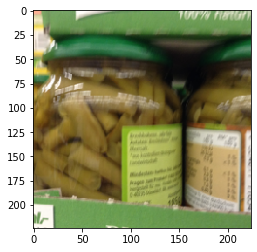

In [4]:
plt.imshow(x_train[100].astype(int))

In [5]:
class_names[:5]

['BEANS', 'CAKE', 'CANDY', 'CEREAL', 'CHIPS']

(array([639., 439., 672., 199., 406., 602., 295., 504., 381., 560.]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

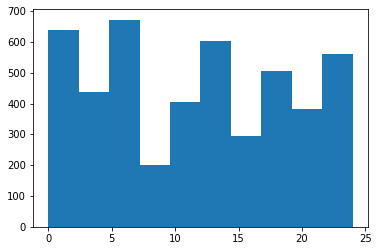

In [6]:
plt.hist(y_train_raw)

In [7]:
y_train = keras.utils.to_categorical(y_train_raw)
y_test = keras.utils.to_categorical(y_test_raw)

In [8]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [9]:
x_train_normalized = x_train/255.
x_test_normalized = x_test/255.

In [11]:
### Simple NN
model = Sequential()
model.add(Flatten())
model.add(Dense(25,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = "adam",
              metrics = ['accuracy'])
model.fit(x_train_normalized,y_train,epochs=10, validation_data=(x_test_normalized,y_test),
          )


Epoch 1/10
147/147 [==============================] - 5s 13ms/step - loss: 83.5678 - accuracy: 0.0721 - val_loss: 41.2598 - val_accuracy: 0.0800
Epoch 2/10
147/147 [==============================] - 2s 12ms/step - loss: 28.4539 - accuracy: 0.1630 - val_loss: 38.5753 - val_accuracy: 0.0960
Epoch 3/10
147/147 [==============================] - 2s 12ms/step - loss: 23.5471 - accuracy: 0.1890 - val_loss: 30.4221 - val_accuracy: 0.0680
Epoch 4/10
147/147 [==============================] - 2s 12ms/step - loss: 19.0341 - accuracy: 0.2429 - val_loss: 40.6669 - val_accuracy: 0.0680
Epoch 5/10
147/147 [==============================] - 2s 12ms/step - loss: 24.3744 - accuracy: 0.2517 - val_loss: 32.8222 - val_accuracy: 0.0720
Epoch 6/10
147/147 [==============================] - 2s 12ms/step - loss: 14.2449 - accuracy: 0.3273 - val_loss: 34.6240 - val_accuracy: 0.0720
Epoch 7/10
147/147 [==============================] - 2s 12ms/step - loss: 15.9888 - accuracy: 0.3323 - val_loss: 25.0082 - val_ac

**Type 1: Using Pretrained Model as Feature Extractor**

In [10]:
resnet_model = ResNet50(weights="imagenet")

In [11]:
x_train_preprocessed = preprocess_input(x_train)
x_test_preprocessed = preprocess_input(x_test)

In [12]:
#Build a new model that is ResNet5 minus the very last layer
last_layer = resnet_model.get_layer('avg_pool')

resnet_layers = keras.Model(inputs=resnet_model.inputs, outputs= last_layer.output)

In [15]:
#We use out resnet to predict but because we have removed the top layer,
#this outputs the activations of the second to last layer on our dataset
x_train_features = resnet_layers.predict(x_train_preprocessed)
x_test_features = resnet_layers.predict(x_test_preprocessed)

In [16]:
feature_model = Sequential()
feature_model.add(Dense(25,activation='softmax'))
feature_model.compile(loss="categorical_crossentropy",
                      optimizer ="adam",metrics=["accuracy"])
feature_model.fit(x_train_features,y_train,epochs=50,
                 validation_data = (x_test_features,y_test))

Epoch 1/50
147/147 [==============================] - 1s 3ms/step - loss: 2.3295 - accuracy: 0.3493 - val_loss: 1.3641 - val_accuracy: 0.5640
Epoch 2/50
147/147 [==============================] - 0s 2ms/step - loss: 0.7608 - accuracy: 0.7919 - val_loss: 1.1041 - val_accuracy: 0.6480
Epoch 3/50
147/147 [==============================] - 0s 2ms/step - loss: 0.4972 - accuracy: 0.8738 - val_loss: 1.0439 - val_accuracy: 0.6800
Epoch 4/50
147/147 [==============================] - 0s 2ms/step - loss: 0.3823 - accuracy: 0.9060 - val_loss: 0.9083 - val_accuracy: 0.7120
Epoch 5/50
147/147 [==============================] - 0s 2ms/step - loss: 0.2863 - accuracy: 0.9453 - val_loss: 0.8607 - val_accuracy: 0.7240
Epoch 6/50
147/147 [==============================] - 0s 2ms/step - loss: 0.2163 - accuracy: 0.9640 - val_loss: 0.8980 - val_accuracy: 0.6920
Epoch 7/50
147/147 [==============================] - 0s 2ms/step - loss: 0.1768 - accuracy: 0.9744 - val_loss: 0.8366 - val_accuracy: 0.7320
Epoch 

**Type 2: Using pretrained model as a layer without trainable weights**

In [13]:
model = Sequential()
model.add(resnet_layers)
model.add(Dense(25,activation='softmax'))
model.layers[0].trainable = False
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 25)                51225     
Total params: 23,638,937
Trainable params: 51,225
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
model.fit(x_train_preprocessed,y_train,epochs=50,
          validation_data=(x_test_preprocessed,y_test))

Epoch 1/50
147/147 [==============================] - 13s 70ms/step - loss: 2.2423 - accuracy: 0.3832 - val_loss: 1.4454 - val_accuracy: 0.5360
Epoch 2/50
147/147 [==============================] - 9s 63ms/step - loss: 0.7708 - accuracy: 0.7746 - val_loss: 1.2094 - val_accuracy: 0.5960
Epoch 3/50
147/147 [==============================] - 9s 63ms/step - loss: 0.5029 - accuracy: 0.8717 - val_loss: 0.9879 - val_accuracy: 0.6760
Epoch 4/50
147/147 [==============================] - 9s 63ms/step - loss: 0.3730 - accuracy: 0.9085 - val_loss: 0.8856 - val_accuracy: 0.7160
Epoch 5/50
147/147 [==============================] - 9s 63ms/step - loss: 0.2676 - accuracy: 0.9492 - val_loss: 0.8742 - val_accuracy: 0.6920
Epoch 6/50
147/147 [==============================] - 9s 63ms/step - loss: 0.2139 - accuracy: 0.9649 - val_loss: 0.8745 - val_accuracy: 0.7000
Epoch 7/50
147/147 [==============================] - 9s 63ms/step - loss: 0.1711 - accuracy: 0.9765 - val_loss: 0.8809 - val_accuracy: 0.716

**Type 3: Using Pretrained weights as a starting point not random weights**

In [14]:
# We can allow some of the resnet layers to change as we train.  
# Typically you would want to lower the learning rate in conjunction with this.

model.layers[0].trainable = True

# We let the last 3 blocks train
for layer in model.layers[0].layers[:-11]:
    layer.trainable = False
for layer in model.layers[0].layers[-11:]:
    layer.trainable = True
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train_preprocessed, y_train, epochs=50, 
              validation_data=(x_test_preprocessed, y_test))

Epoch 1/50
147/147 [==============================] - 45s 79ms/step - loss: 1.7924 - accuracy: 0.5076 - val_loss: 2.6850 - val_accuracy: 0.4960
Epoch 2/50
147/147 [==============================] - 10s 68ms/step - loss: 0.3398 - accuracy: 0.8954 - val_loss: 1.2497 - val_accuracy: 0.6720
Epoch 3/50
147/147 [==============================] - 10s 67ms/step - loss: 0.1870 - accuracy: 0.9474 - val_loss: 1.8701 - val_accuracy: 0.6000
Epoch 4/50
147/147 [==============================] - 10s 68ms/step - loss: 0.0936 - accuracy: 0.9750 - val_loss: 0.9631 - val_accuracy: 0.7160
Epoch 5/50
147/147 [==============================] - 10s 68ms/step - loss: 0.0434 - accuracy: 0.9870 - val_loss: 1.1464 - val_accuracy: 0.7120
Epoch 6/50
147/147 [==============================] - 10s 68ms/step - loss: 0.0409 - accuracy: 0.9903 - val_loss: 1.4547 - val_accuracy: 0.6760
Epoch 7/50
147/147 [==============================] - 10s 68ms/step - loss: 0.0450 - accuracy: 0.9891 - val_loss: 0.9340 - val_accuracy: